In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from AReS import Simulator, SimulatorMode, Model, Interaction, DoHMeasure, TciMode

In [8]:
def plot_trace(ax, x, y_data, ylabel, id_ref, label_prefix=None, color=None, add_legend=False):
    """
    Plot a trace with shaded min/max variability on a given axis.
    """
    y_data = np.array(y_data)
    y_ref = y_data[id_ref] # Plot the reference trace
    y_min = np.min(y_data, axis=0) # Min trace
    y_max = np.max(y_data, axis=0) # Max trace

    if color is None:
        colormap = plt.colormaps['tab10']
        color = colormap(len(ax.lines) % 10)  # tab10 has 10 distinct colors, avoid going over

    label_prefix = '' if label_prefix is None else label_prefix
    ax.plot(x, y_ref, color=color, label=f'{label_prefix} Mean Trace')  # Main trace (mean)
    ax.fill_between(x, y_min, y_max, color=color, alpha=0.2, label=f'{label_prefix} Min/Max Range')  # Shaded area (min/max)
    ax.set_xlabel('Time [min]')
    ax.set_ylabel(ylabel)
    ax.grid(True)
    if add_legend:
        ax.legend(loc="upper right")


def plot_data(data, id_ref, field=None, labels=None):
    """
    Plot a single scenario's patient response with variability for multiple data fields.
    """
    if field is None:
        fields = [
            '_u_prop_all', '_u_remi_all', '_cp_prop_all', '_cp_remi_all', '_ce_prop_all', '_ce_remi_all', '_u_nore_all', '_c_nore_all',
            '_WAV_all', '_BIS_all', '_MAP_all', '_CO_all', '_HR_all', '_SV_all'
        ]

        labels = [
            '$u_{Prop} [mg/s]$', '$u_{Remi} [μg/s]$', '$C_{p,prop} [μg/ml]$', '$C_{p,remi} [ng/ml]$',
            '$C_{e,prop} [μg/ml]$', '$C_{e,remi} [ng/ml]$',
            '$u_{Nore} [μg/s]$', '$C_{nore} [ng/ml]$',
            'wav$_{cns}$', 'BIS', 'MAP [mmHg]',
            'CO [L/min]', 'HR [beats/min]', 'SV [ml]'
        ]
    else:
        fields = field
        labels = labels

    data_values = [data[field] for field in fields]
    t_sim = np.arange(0, len(data['_u_prop_all'][0]))/60  # Time vector

    cols = 2
    rows = len(data_values) // cols
    subplot_width = 7
    subplot_height = 3
    fig_width = subplot_width * cols
    fig_height = subplot_height * rows
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height)) 

    for i, (values, label) in enumerate(zip(data_values, labels)):
        plot_trace(axs[i // 2, i % 2], t_sim, values, label, id_ref)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [15]:
def calculate_ss_stats(values_array):
    """
    Calculate mean, standard deviation, and percentiles for values_array.
    """
    results = {}
    if not values_array or all(len(arr) == 0 for arr in values_array):
        return None, None, None
    steady_state_values = [arr[-1] for arr in values_array if len(arr) > 0] # Get the last value of each simulation

    mean = np.round(np.mean(steady_state_values), 2) if steady_state_values else None # mean of the steady state values
    std = np.round(np.std(steady_state_values, ddof=1), 2) if len(steady_state_values) > 1 else 0 # standard deviation of the steady state values
    percentiles = np.round(np.percentile(steady_state_values, [0, 25, 50, 75, 100]), # percentiles of the steady state values
                           2).tolist() if steady_state_values else [None, None, None, None, None]
    results['mean'] = mean
    results['std'] = std
    results['percentiles'] = percentiles
    return results

def calculate_peak_stats(values_array):
    """
    Calculate mean, standard deviation, and percentiles for peak values and times.
    """
    if not values_array or all(len(arr) == 0 for arr in values_array):
        return None, None, None, None, None, None

    # Compute peak values and their indices.
    peak_values = [np.max(arr) for arr in values_array if len(arr) > 0] # Get the peak value of each simulation
    peak_times = [np.argmax(arr) for arr in values_array if len(arr) > 0] # Get the time of the peak value of each simulation

    # Calculate and round statistics for peak values
    peak_mean = np.round(np.mean(peak_values), 2) if peak_values else None # mean of the peak values
    peak_std = np.round(np.std(peak_values, ddof=1), 2) if len(peak_values) > 1 else 0 # standard deviation of the peak values
    peak_percentiles = np.round(np.percentile(peak_values, [0, 25, 50, 75, 100]), 2).tolist() if peak_values else [None, # percentiles of the peak values
                                                                                                                   None,
                                                                                                                   None,
                                                                                                                   None,
                                                                                                                   None]
    # Calculate and round statistics for peak times
    time_mean = np.round(np.mean(peak_times), 2) if peak_times else None # mean of the peak times
    time_std = np.round(np.std(peak_times, ddof=1), 2) if len(peak_times) > 1 else 0 # standard deviation of the peak times
    time_percentiles = np.round(np.percentile(peak_times, [0, 25, 50, 75, 100]), 2).tolist() if peak_times else [None, # percentiles of the peak times
                                                                                                                 None,
                                                                                                                 None,
                                                                                                                 None,
                                                                                                                 None]
    results = {}
    results['peak_mean'] = peak_mean
    results['peak_std'] = peak_std
    results['peak_percentiles'] = peak_percentiles
    results['time_mean'] = time_mean
    results['time_std'] = time_std
    results['time_percentiles'] = time_percentiles
    return results


def plot_boxplots(results, variables, scenario_indexes, cmap_name="tab10", figsize=(6, 4)):
    """
    Generate box plots with scatter points for comparison of specified variables across scenarios,
    connecting scatter points across scenarios with lines. Highlight the line with the greatest difference.
    """
    colormap = plt.colormaps[cmap_name]

    # variable is a dictionary with the variable name as key and the label as value
    # variables = {'_BIS_all': 'BIS'}
    for variable, label in variables.items():
        data = {}
        # results is a dictionary with scenario names as keys and data as values
        for i, (scenario, values) in enumerate(results.items(), start=1):
            if variable in values:
                # values[variable] is an array of arrays, each array is the simulation results for a field
                # data is a dictionary the number of the scenario as key and the last value of the simulation of the field as value
                # if variable = '_BIS_all'
                # data[1] = an array containing the last value of each simulation of the field '_BIS_all' for scenario 1
                data[f"{scenario_indexes[i-1]}"] = [simulation[-1] for simulation in values[variable] if len(simulation) > 0]

        if not data:
            print(f"No data found for variable {variable}. Skipping.")
            continue

        y_values = list(data.values()) # get the values of the dictionary
        labels = list(data.keys()) # get the keys of the dictionary

        plt.figure(figsize=figsize)
        plt.boxplot(y_values, positions=range(len(labels)), medianprops=dict(color='blue'))

        num_points = len(next(iter(data.values()))) # num_points is calculated as the length of the first list within the dictionary data = the number of simulations
        x = np.random.uniform(-0.2, 0.2, num_points) # generate random x values for the scatter points

        max_diff = 0
        max_diff_idx = -1

        for id in range(num_points): 
            # print(f'Values for patient {id}: {[scatter_y[i][id] for i in range(len(data))]}')

            # diffs contains the differences between  the steady state values for each patient across scenarios
            diffs = [abs(y_values[i][id] - y_values[j][id]) for i in range(len(data)) for j in range(i + 1, len(data))]
            # print(f"Diff for patient {id}: {diffs}")
            # if diffs:
            #     print(f"Max diff for patient {id}: {max(diffs)}")
            if diffs and max(diffs) > max_diff:
                max_diff = max(diffs)
                max_diff_idx = id

        # Adding scatter points and lines
        for i, (col, points) in enumerate(data.items()):
            color = colormap(i / len(data))
            scatter_x = x + i # the scatter point corresponding to each patient is placed in the same x position (related to the scenario)
            plt.scatter(scatter_x, points, alpha=0.6, s=15, color=color, label=col if i == 0 else None)
            # add the patient id to the scatter points
            # for j, txt in enumerate(points):
            #     plt.annotate(j, (scatter_x[j], points[j]), fontsize=4)

        for id in range(num_points):
            line_x = [x[id] + i for i in range(len(data))] # x values for the line corresponding to each patient
            line_y = [y_values[i][id] for i in range(len(data))] # y values for the line corresponding to each patient

            # Highlight the line with the maximum difference
            if id == max_diff_idx:
                plt.plot(line_x, line_y, color='red', linewidth=0.5)
                # plt.text(line_x[-1] + 0.1, line_y[-1], f"{id + 1}", color='red',fontsize=8)
            elif id == 37: # the patient with the lowest value of wav
                plt.plot(line_x, line_y, color='blue', linewidth=0.5)
            else:
                plt.plot(line_x, line_y, color='gray', alpha=0.5, linewidth=0.5)
            # add a label for the patient id at the end of the line
            # plt.text(line_x[-1] + 0.1, line_y[-1], f"{id}", color='black', fontsize=4)

        plt.ylabel(label,fontsize=18)
        plt.xlabel("Scenario",fontsize=18)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.xticks(range(len(labels)), labels)
        plt.tight_layout()
        plt.savefig('wav_box_plot.pdf', format='pdf')
        plt.show()
        
        plt.close()
        
def compute_statistics_experiment(results):
    stats = {}
    keys = list(results.keys())
    
    for i in range (1,7):
        
        print(f"---------- Statistics for scenario {i} ----------")
        print ("\n")
        
        values = results[keys[i-1]]
        # Steady state calculations for u_prop, u_remi, u_nore, cp_prop, cp_remi
        stats['ss_u_prop'] = calculate_ss_stats(values.get("_u_prop_all", []))
        stats['ss_u_remi']= calculate_ss_stats(values.get("_u_remi_all", []))

        # Peak stats calculations
        stats['peak_cp_prop'] = calculate_peak_stats(values.get("_cp_prop_all", []))
        stats['peak_cp_remi'] = calculate_peak_stats(values.get("_cp_remi_all", []))

        # General steady state stats calculations for other parameters
        stats['wav'] = calculate_ss_stats(values.get("_WAV_all", []))
        stats['bis'] = calculate_ss_stats(values.get("_BIS_all", []))
        stats['map'] = calculate_ss_stats(values.get("_MAP_all", []))
        stats['hr'] = calculate_ss_stats(values.get("_HR_all", []))
        stats['co'] = calculate_ss_stats(values.get("_CO_all", []))
        stats['sv'] = calculate_ss_stats(values.get("_SV_all", []))
    
        for key, value in stats.items():
            print(f"{key}: {value}")
            
        print ("\n")
        print("---------- End of statistics ----------")
        
    plot_boxplots(results, {'_WAV_all': 'wav'}, ['1', '2', '3', '4', '5', '6'])
    

In [4]:
def run_simulations():
    simulation_params = [
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.ELEVELD},
         'pd_models': {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}},
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.MINTO},
         'pd_models': {'prop': Model.ELEVELD, 'remi': Model.MINTO}},
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.ELEVELD},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}},
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.MINTO},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.MINTO}},
        {'pk_models': {'prop': Model.SCHNIDER, 'remi': Model.ELEVELD},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}},
        {'pk_models': {'prop': Model.SCHNIDER, 'remi': Model.MINTO},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.MINTO}}
    ]

    interaction = Interaction.SURFACE
    doh_measure = DoHMeasure.BOTH
    modes_tci = {'prop': TciMode.EFFECT_SITE, 'remi': TciMode.EFFECT_SITE}
    limits_tci = {'cp_limit_prop': 10, 'cp_limit_remi': 10, 'infusion_limit_prop': 2,
                  'infusion_limit_remi': 0.5}
    t_s = 5
    t_sim = 60 * 30

    # Input Variables
    target_prop = [2] * t_sim
    target_remi = [3.6] * t_sim
    target_nore = [0] * t_sim
    target_rocu = [0] * t_sim
    
    simulator = Simulator.create(SimulatorMode.CONCENTRATION)
    results = {}

    for i, params in enumerate(simulation_params, start=1):
        print(f"Running simulation {i}/{len(simulation_params)}")
        for patient_id in range(44):
            seed = patient_id
            simulator.init_simulation_from_file(
                id_patient=patient_id, t_sim=t_sim, t_s=t_s,
                pk_models=params['pk_models'], pd_models=params['pd_models'],
                pk_models_TCI=params['pk_models'], pd_models_TCI=params['pd_models'],
                interaction=interaction, doh_measure=doh_measure,  
                limits_TCI=limits_tci, modes_TCI=modes_tci,
                seed_variability = seed
            )
            simulator.run_complete_simulation(target_prop, target_remi, target_nore, target_rocu)
            simulator.save_simulation()

        data = simulator.get_patient_results()
        pk_models_names = [model.name for model in params['pk_models'].values()]
        pd_models_names = [model.name for model in params['pd_models'].values()]
        simulation_key = f"pk_models: {pk_models_names}, pd_models: {pd_models_names}"
        results[simulation_key] = data

        id_ref = 29
        plot_data(data, id_ref,None, None)
        simulator.reset()

    return results

Running simulation 1/6


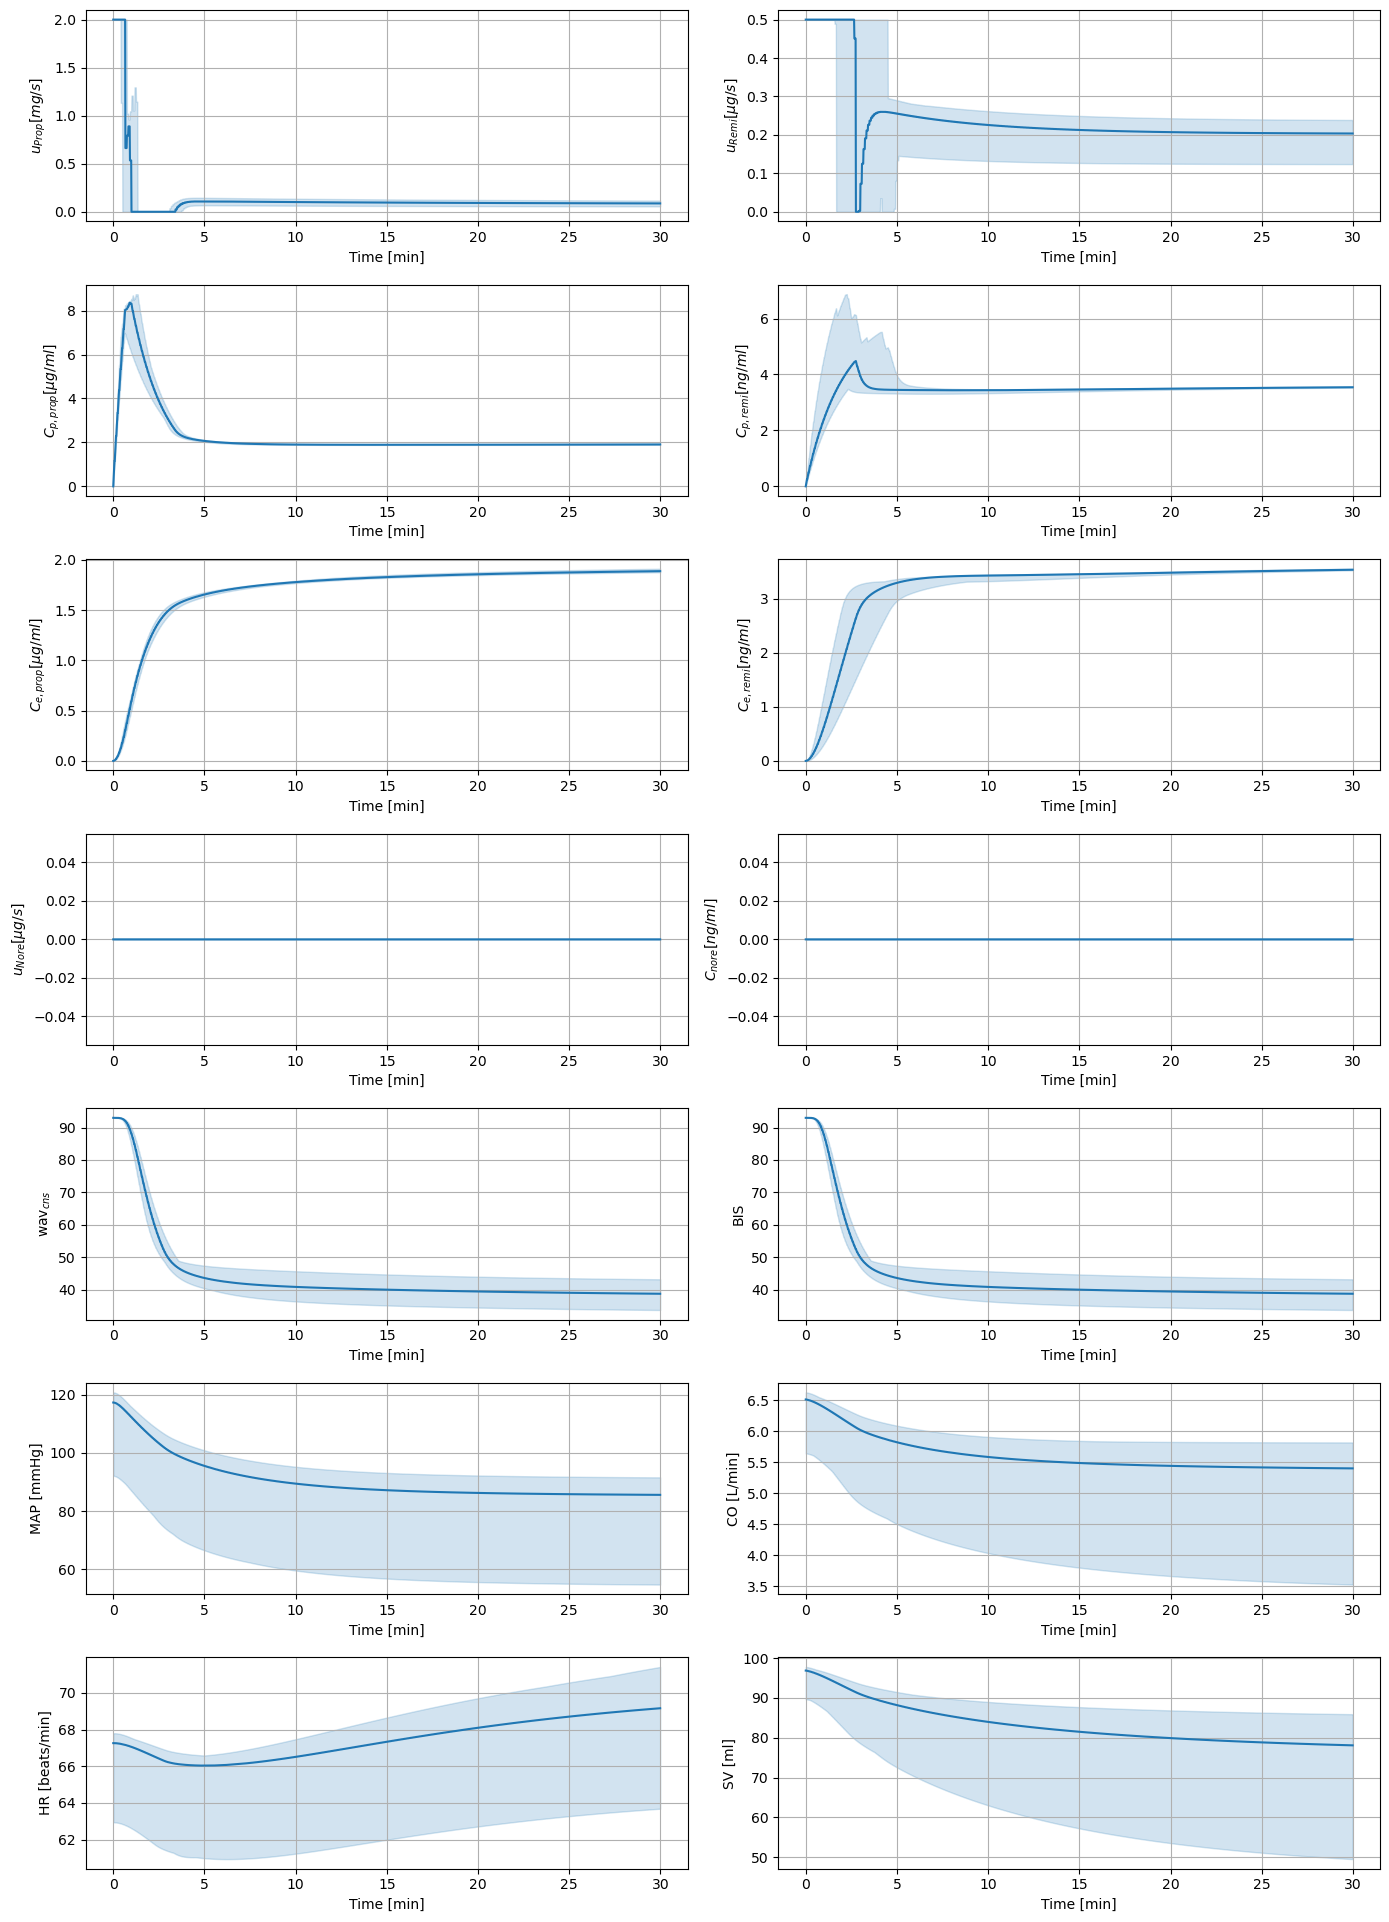

Running simulation 2/6


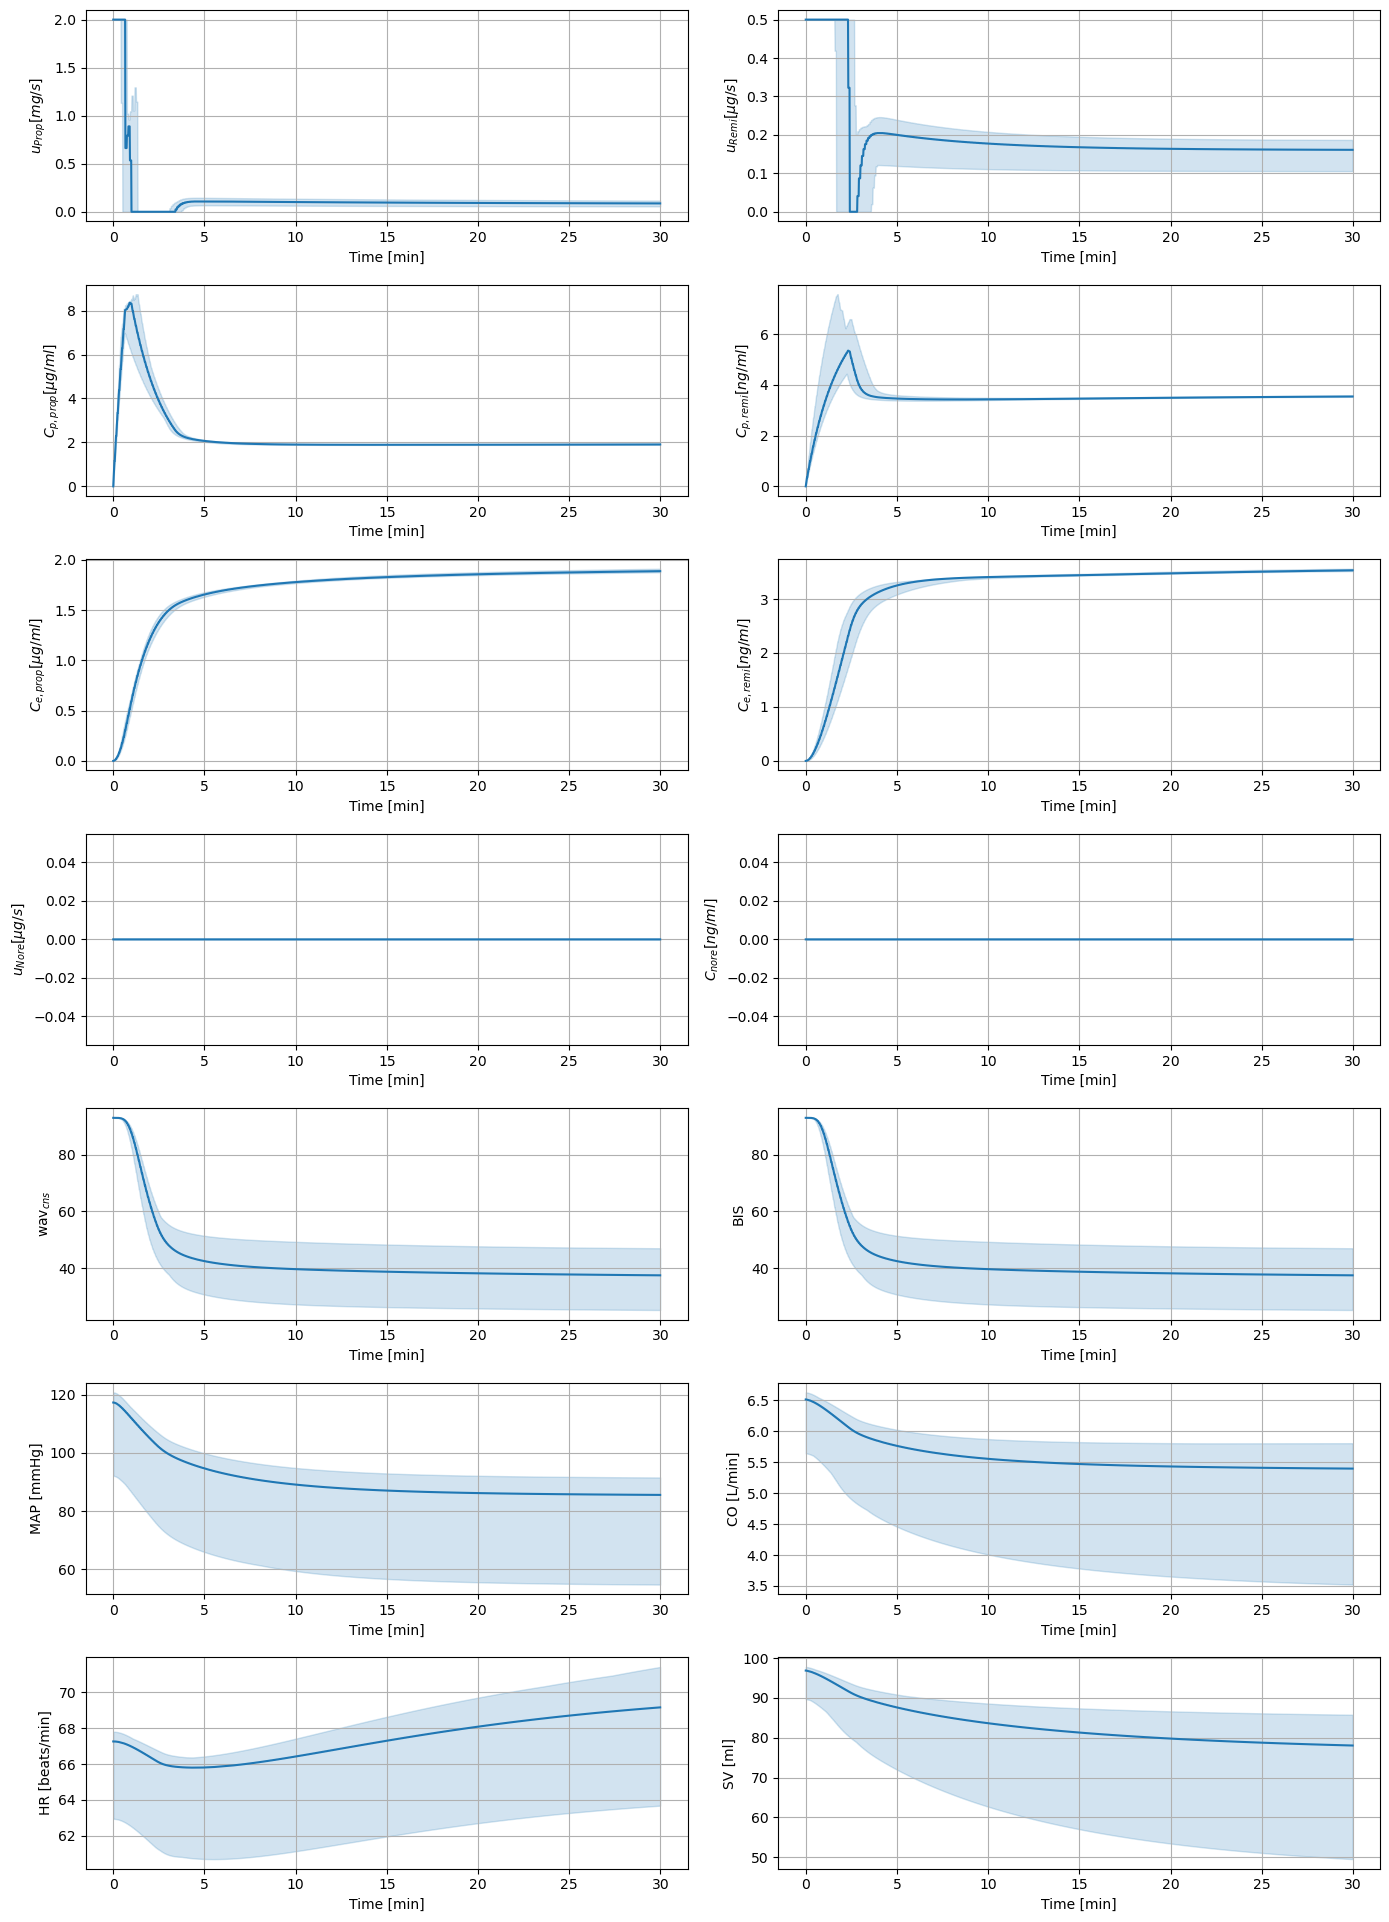

Running simulation 3/6


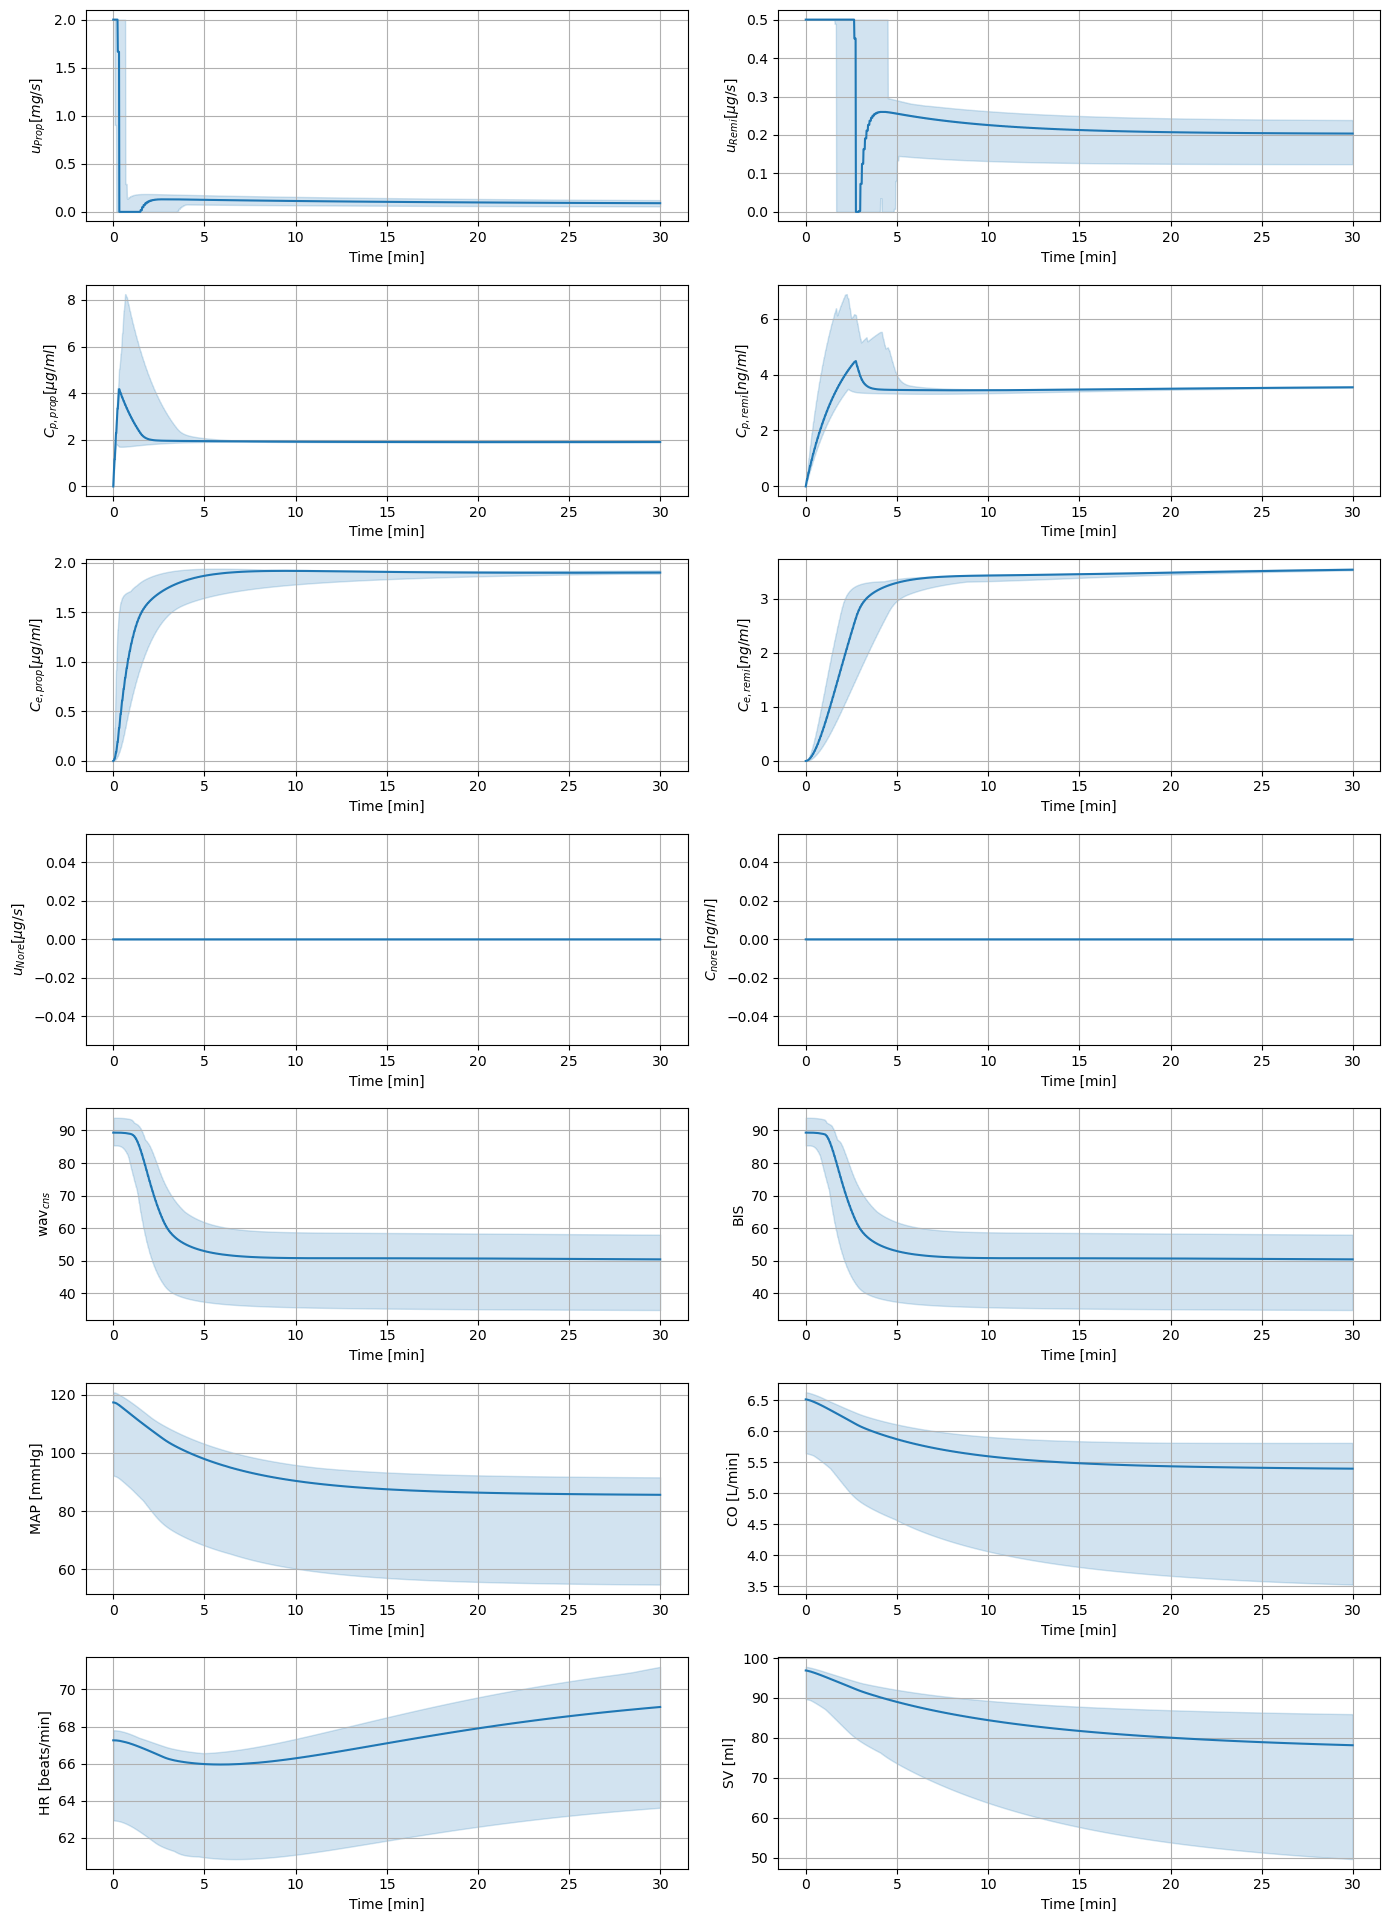

Running simulation 4/6


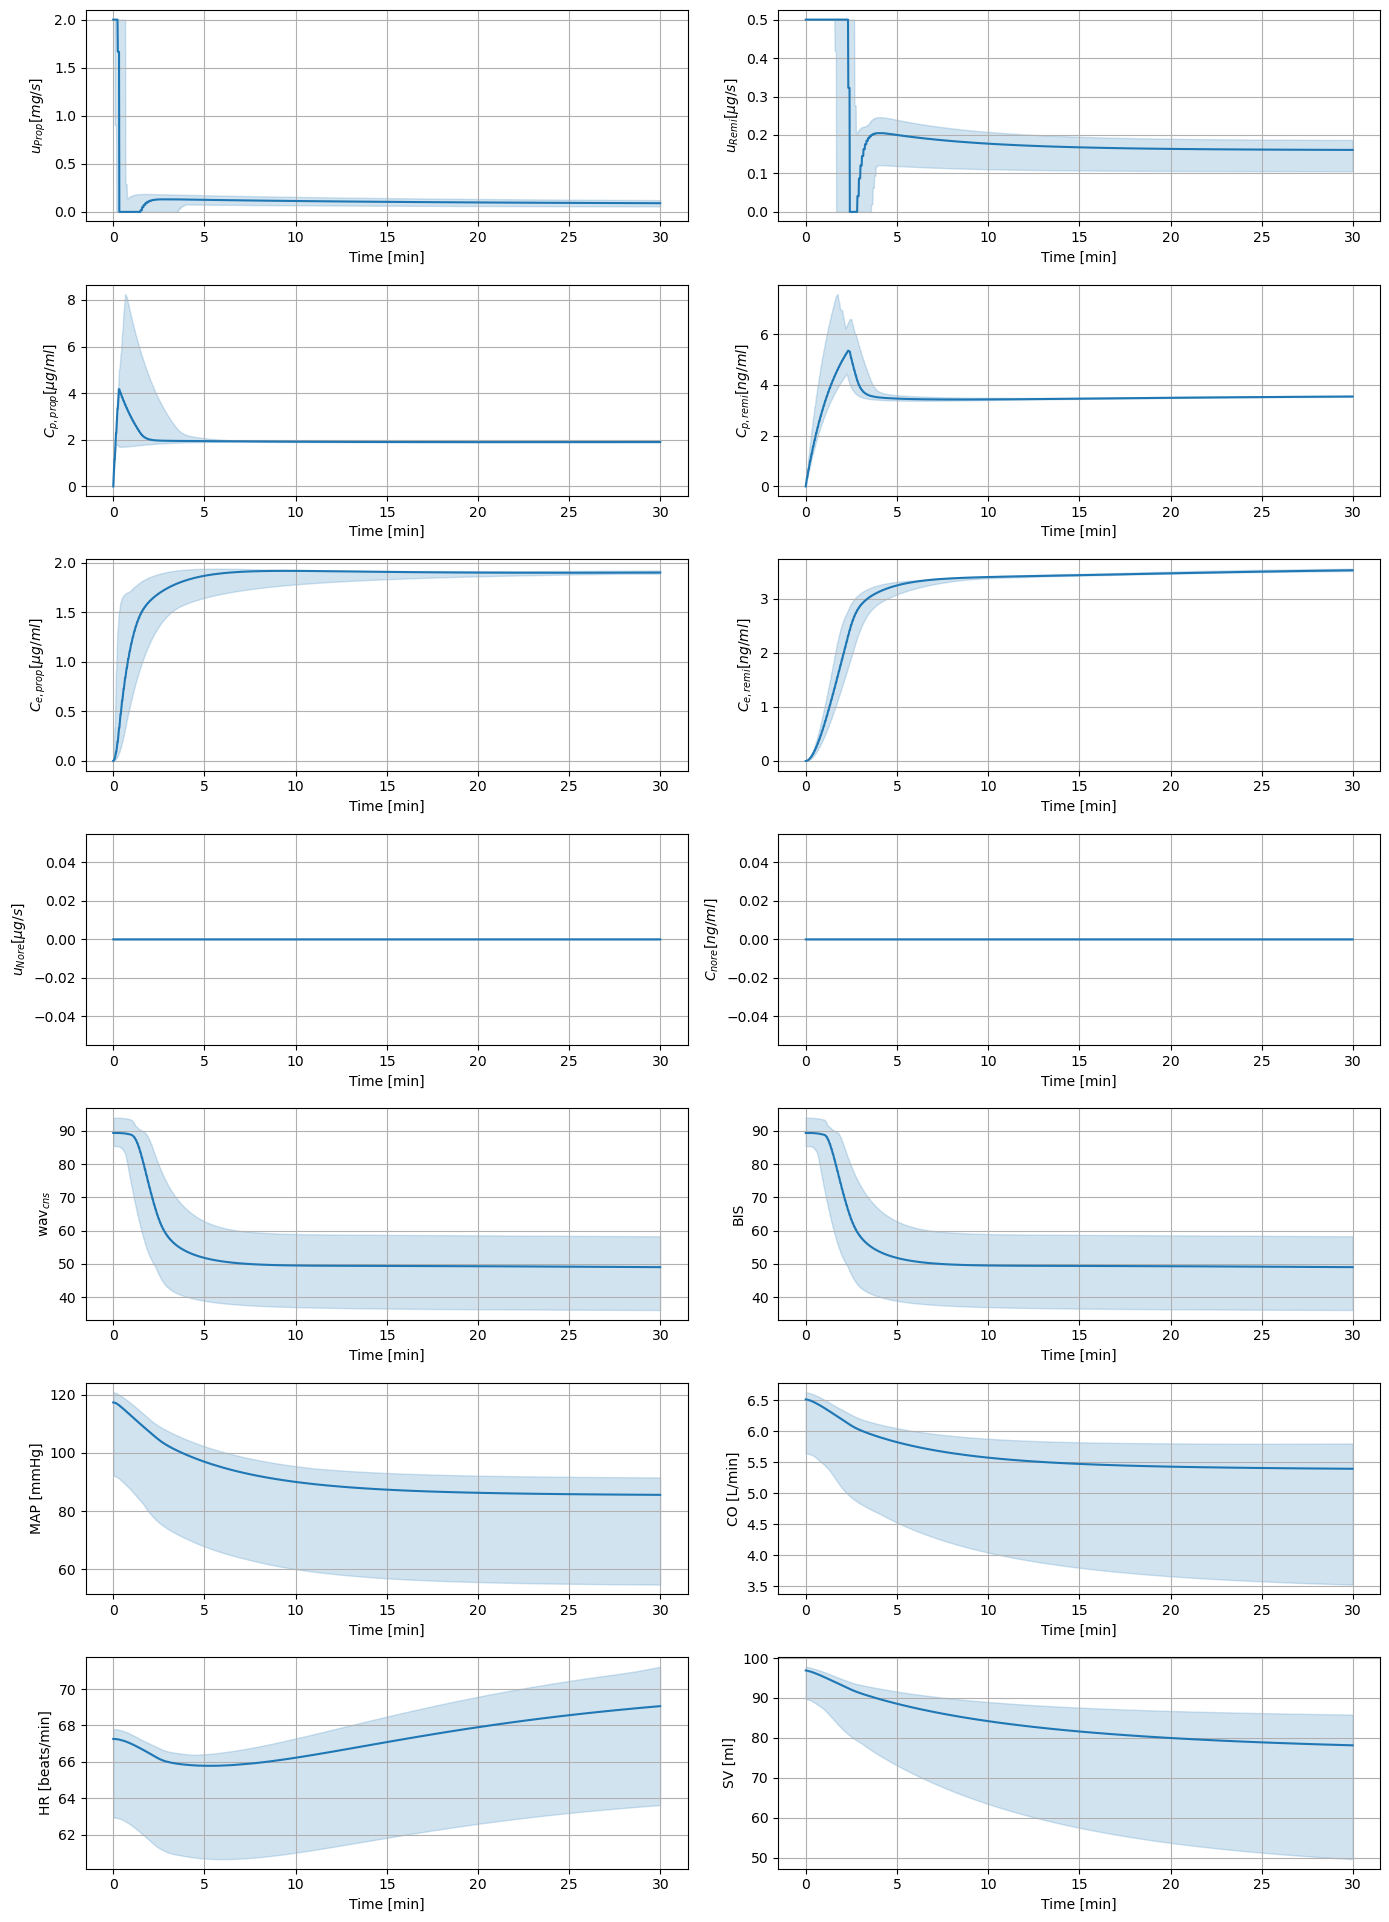

Running simulation 5/6


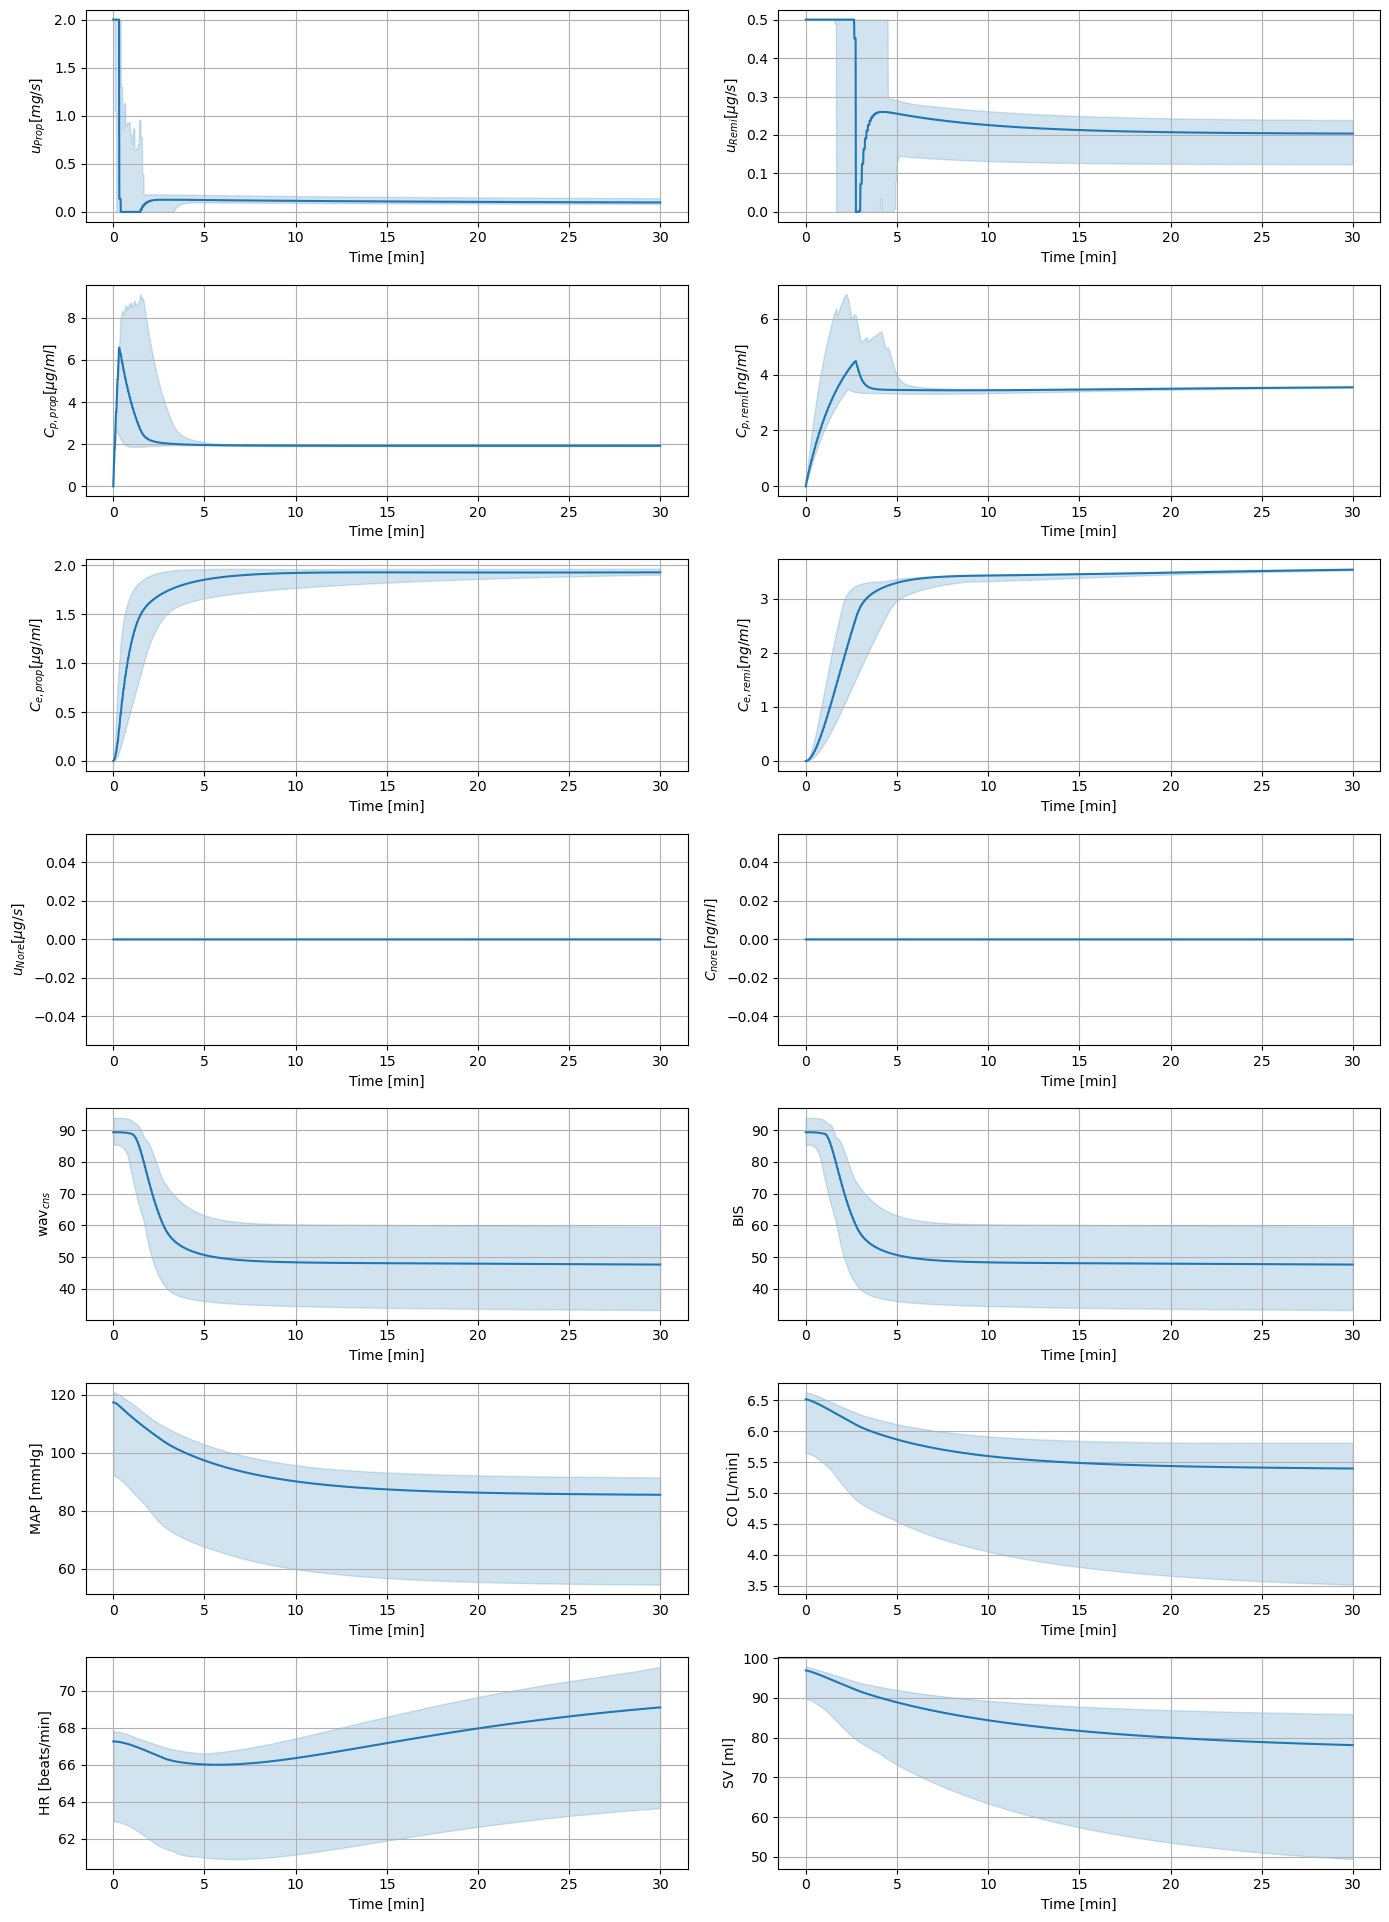

Running simulation 6/6


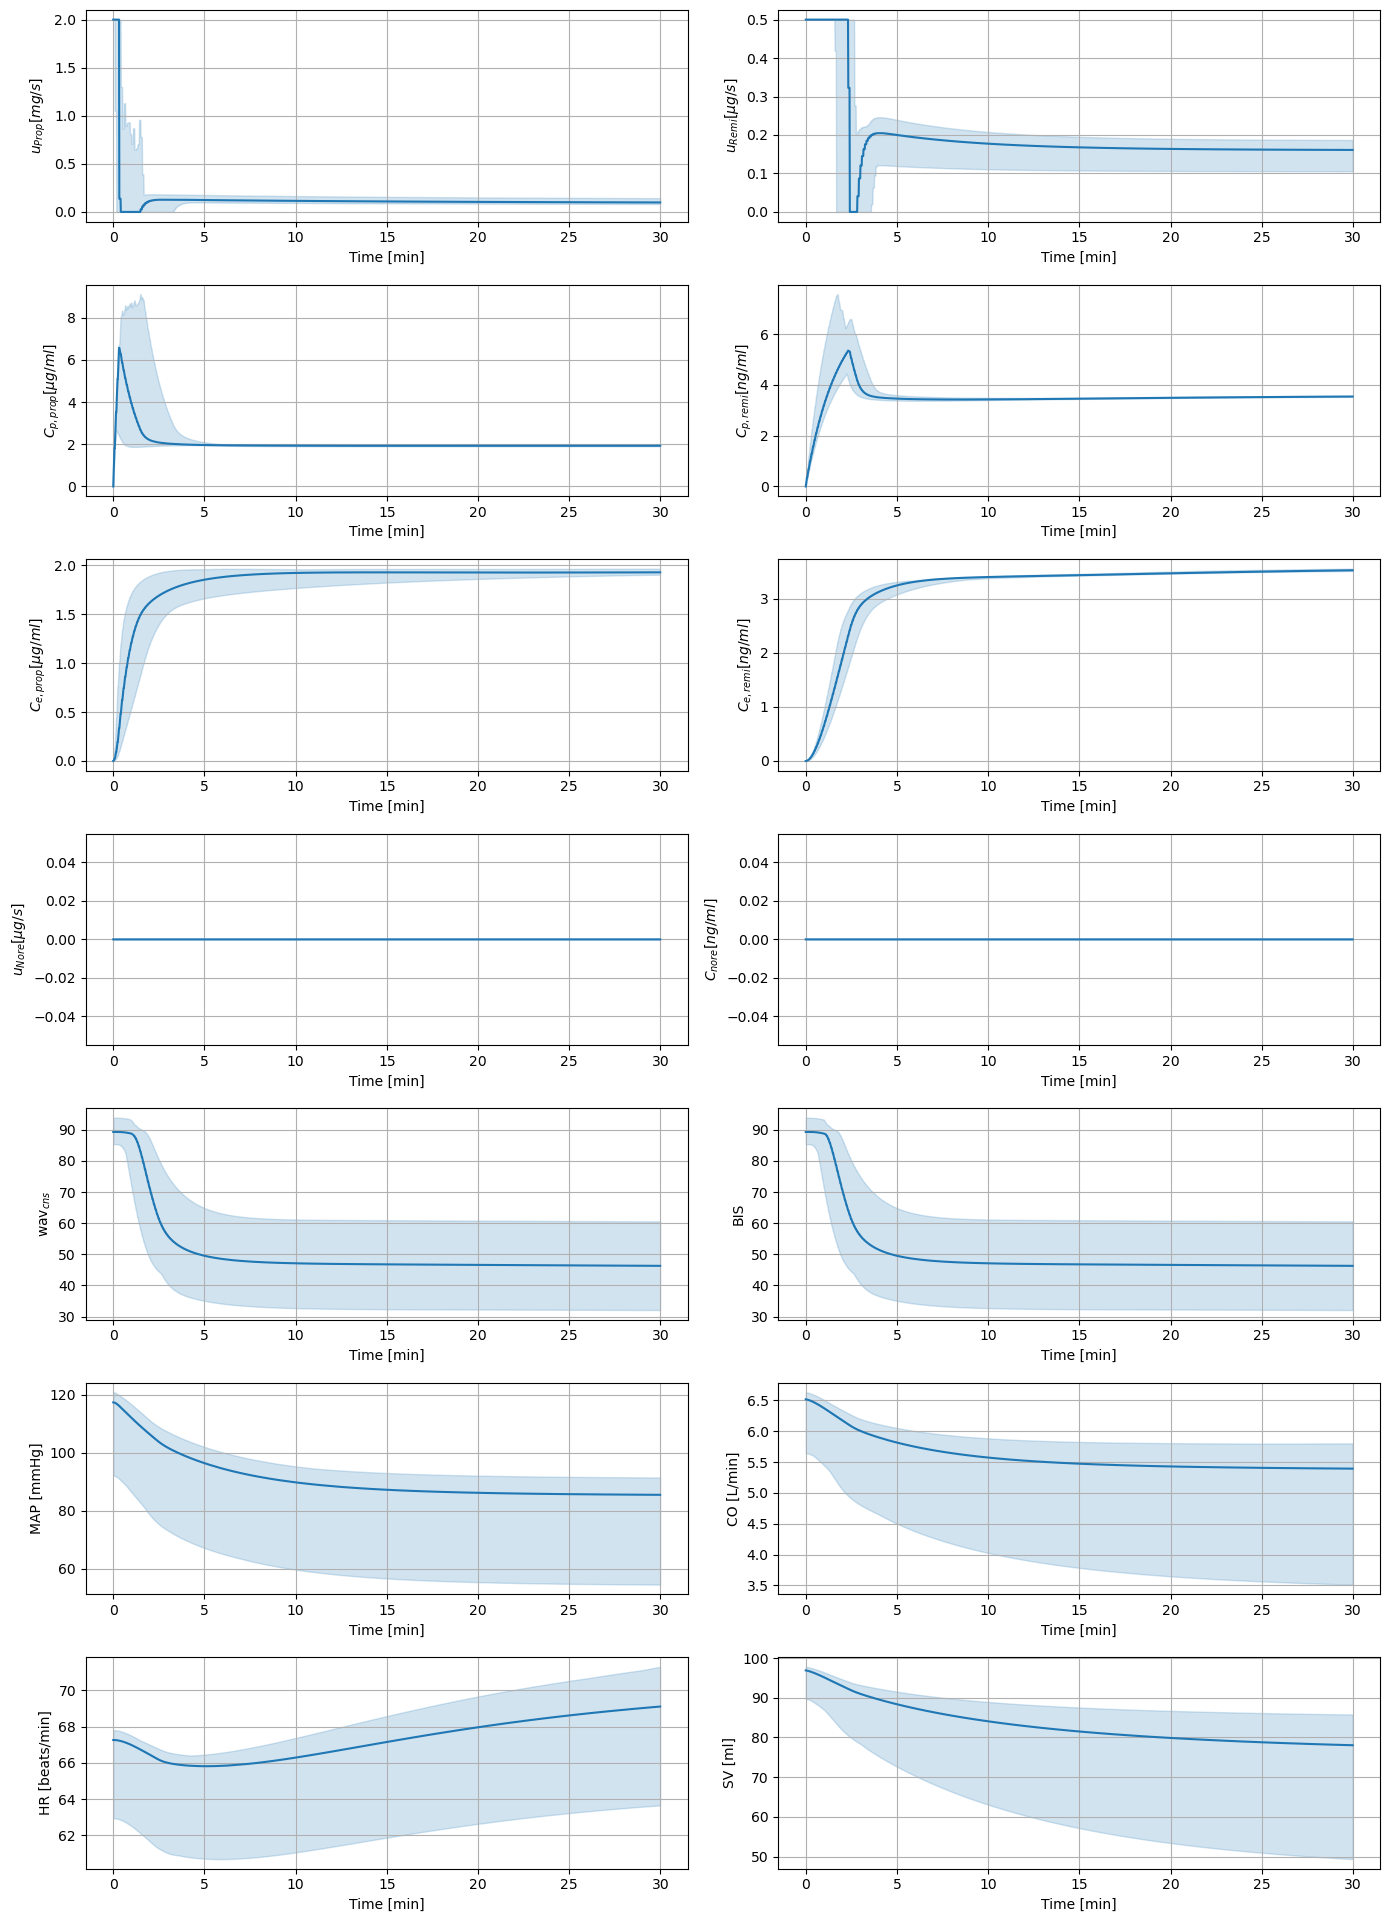

In [5]:
results = run_simulations()

---------- Statistics for scenario 1 ----------


ss_u_prop: {'mean': np.float64(0.09), 'std': np.float64(0.01), 'percentiles': [0.06, 0.08, 0.09, 0.1, 0.12]}
ss_u_remi: {'mean': np.float64(0.19), 'std': np.float64(0.03), 'percentiles': [0.12, 0.17, 0.19, 0.21, 0.24]}
peak_cp_prop: {'peak_mean': np.float64(8.34), 'peak_std': np.float64(0.28), 'peak_percentiles': [7.4, 8.24, 8.39, 8.49, 8.75], 'time_mean': np.float64(53.09), 'time_std': np.float64(12.5), 'time_percentiles': [29.0, 44.0, 54.0, 64.0, 79.0]}
peak_cp_remi: {'peak_mean': np.float64(4.93), 'peak_std': np.float64(0.72), 'peak_percentiles': [3.85, 4.48, 4.9, 5.17, 6.87], 'time_mean': np.float64(162.41), 'time_std': np.float64(38.44), 'time_percentiles': [99.0, 134.0, 159.0, 184.0, 269.0]}
wav: {'mean': np.float64(37.72), 'std': np.float64(2.3), 'percentiles': [33.71, 36.18, 37.52, 39.73, 43.19]}
bis: {'mean': np.float64(37.72), 'std': np.float64(2.3), 'percentiles': [33.71, 36.18, 37.52, 39.73, 43.19]}
map: {'mean': np.float64(

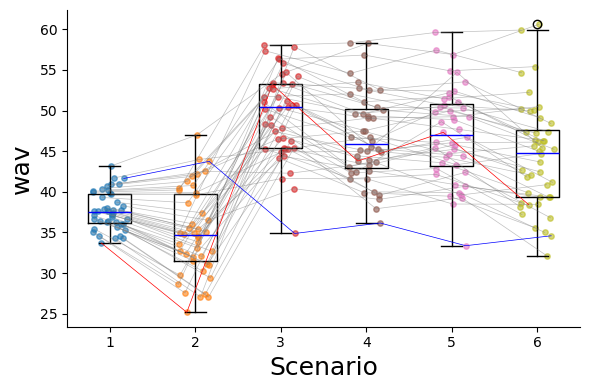

In [16]:
compute_statistics_experiment(results)